# Clustering News

In this notebook, we are going to cluster news articles obtained from the UCI Machine Learning Repository by creating a Bag of Words to represent our article content and then performing Locality-Sensitive Hashing with MinHash on our Bag of Words. Then we will create a graph where each node is an article and each edge is a match based on two articles exceeding the threshold of their estimated Jaccard Similarity (from our LSH). To obtain our clusters of articles we caclulate the connected components of our graph. Finally, we output a sample of the clusters found in our data sample.

<img src="./img/clustering-news.png" alt="Overview Image" width="800"/>

## Data

Data obtained from UCI Machine Learning Repository - https://archive.ics.uci.edu/ml/datasets/News+Aggregator

## Parameters

By default, this notebook:

 - Processes a sample of 50,000 articles (~10%) from the total dataset of ~423,000
 - Uses 128 minhashes to calculate Jaccard similiarity
 - Outputs the first 10 clusters found in our graph, with at least 5 articles (ignoring small clusters) and less than 30 (improves readability) articles   


## Job Description

This job description was listed on a freelancing website:

>We have multiple news articles getting tracked daily, and we want to cluster similar articles together, exactly like google news.

## Imports

We are using `pandas` to read our data and for some preprocessing. We are using `sklearn` to construct our Bag of Words for each article.
We use a combination of `sklearn`, `nltk` and our own custom stopwords to exclude common english words from our Bag of Words model. We are using the `datasketch` package to perform our MinHash and Locality-Sensitive Hashing. Finally we use `networkx` to build our graph, calculate the clusters and draw a sample of the clusters found.

In [78]:
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
import networkx as nx

[nltk_data] Downloading package stopwords to /Users/denis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Training Parameters

Here are some training parameters that can alter our calculations:

 - `SAMPLE_SIZE` -> This sets the number articles to include in our analysis. Can be set to a negative number to include the full dataset.
 - `HASH_NO` -> This sets the number of hashes to create for each article, used to calculate similarity. Lower numbers increase the expected margin of error when estimating Jaccard similarity.

In [79]:
SAMPLE_SIZE = 50000
HASH_NO = 128
PUNCTUATION = string.punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’' + '\xa0'

## Output Parameters

Default - print the first 10 clusters that have between 5 and 30 articles.

 - `PRINT_CLUSTERS` -> The number of subgraphs printed at the end of the notebook.
 - `MIN_ARTICLES` -> Clusters with less nodes than `MIN_ARTICLES` are excluded from the output. 
 - `MAX_ARTICLES` = Clusters with mode nodes than `MAX_ARTICLES` are excluded from the output.

In [80]:
PRINT_CLUSTERS = 10
MIN_ARTICLES = 5
MAX_ARTICLES = 30

## Reading Data

In [81]:
data = pd.read_csv('./data/uci-news-aggregator.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


## Sampling Data

In [82]:
if len(data) > SAMPLE_SIZE and SAMPLE_SIZE > 0:
    data_sample = data.sample(n=SAMPLE_SIZE)
    print("Taking sample of {} rows.".format(SAMPLE_SIZE))
    # Re-index the sample
    data_sample.reset_index(drop=True, inplace=True)
else:
    data_sample = data

# delete the original dataframe
del(data)

Taking sample of 50000 rows.


In [83]:
# Info on sample
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         50000 non-null  int64 
 1   TITLE      50000 non-null  object
 2   URL        50000 non-null  object
 3   PUBLISHER  49999 non-null  object
 4   CATEGORY   50000 non-null  object
 5   STORY      50000 non-null  object
 6   HOSTNAME   50000 non-null  object
 7   TIMESTAMP  50000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.1+ MB


## String Preprocessing

In [84]:
# Remove punctuation
def remove_punctuation(text):
    return str(text).translate(str.maketrans('', '', PUNCTUATION))

# Test function
# remove_punctuation("I'm a tricky? $string 4 you & other's to de@l w!th’”")

data_sample['TITLE'] = data_sample['TITLE'].apply(lambda x: remove_punctuation(x))

## Making Bag of Words

In [85]:
my_stop_words = { 'dont', 'going', 'like', 'say', 'said', 'says', 'thats', 'told', 'did',
                  'im', 'asked', 'come', 'got', 'hes', 'shes', 'theres'
}

In [86]:
# Create custom stopwords list
for word in ENGLISH_STOP_WORDS:
    my_stop_words.add(word)
sw_nltk = stopwords.words('english')
for word in sw_nltk:
    my_stop_words.add(word)

In [87]:
# Create bag of words from title with count, removing stop words 
vectorizer = CountVectorizer(stop_words=my_stop_words)
count = vectorizer.fit_transform(data_sample['TITLE'])

title_words_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=count.toarray())

# Create a list to combine bag of words for each row and add to our news data
bag_of_words_list = list()

for i in range(len(title_words_df)):
    title_words = title_words_df.iloc[i]
    # > 0 = at least one mention in the title
    bag_of_words_list.append(title_words.where(title_words > 0).dropna().index.tolist())

data_sample['BOW'] = bag_of_words_list
del(title_words_df)
del(bag_of_words_list)

## Minhashing

In [88]:
# Perform minhash on bag of words
min_hashed_words = list()
for words in data_sample['BOW']:
    min_hash = MinHash(num_perm=HASH_NO)
    for word in words:
        min_hash.update(word.encode('utf8'))
    min_hashed_words.append(min_hash)
data_sample['min_hashes'] = min_hashed_words

## LSH

In [89]:
# Create LSH index
lsh_near = MinHashLSH(threshold=0.5, num_perm=HASH_NO)

# Insert Minhashed shingles
for i in range(len(data_sample)):
    lsh_near.insert(i, data_sample['min_hashes'][i])

In [90]:
# Query all documents LSH, store any matches
duplicates = dict()
for i in range(len(data_sample)):
    match = lsh_near.query(data_sample['min_hashes'][i])
    if (len(match) > 1):
        match.remove(i)
        duplicates.update({i: match})


## Building Graph

In [91]:
# Create edges in form of tuples
edges = list()
for k, v in duplicates.items():
    for match in v:
        edge = (k, match)
        edges.append(edge)

In [92]:
# Build Graph
G = nx.Graph()
G.add_edges_from(edges)

## Calculating Clusters

In [93]:
connected_components = list(nx.connected_components(G))

In [94]:
### DON'T DRAW IF SAMPLE IS LARGE e.g. >1000
# nx.draw(G, width=2, edgecolors='black')

# Results

In [95]:
# Store the clusters using the top tags as key
number_of_top_tags = 7

clusters = dict()

for matches in connected_components:
    ids = list()
    tags = dict()
    for match in matches:
        for word in data_sample['BOW'].iloc[match]:
            if word not in tags.keys():
                tags.update({word:1})
            else:
                tags.update({word:tags[word]+1})
        ids.append(match)
    tags = sorted(tags.items(),key= lambda x:x[1], reverse=True)[:number_of_top_tags]
    clusters.update({str(tags):ids})


In [96]:
print(f'{len(clusters)} clusters found from {len(data_sample)} articles.')

4112 clusters found from 50000 articles.


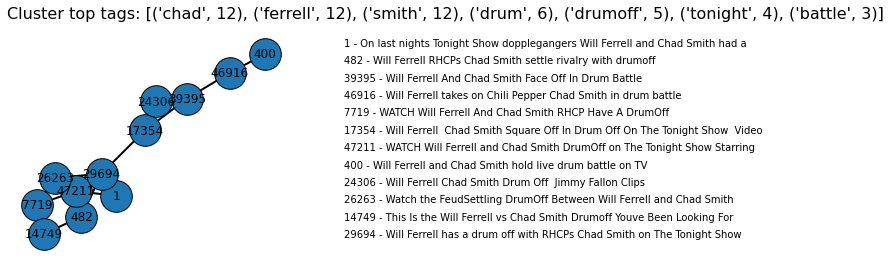

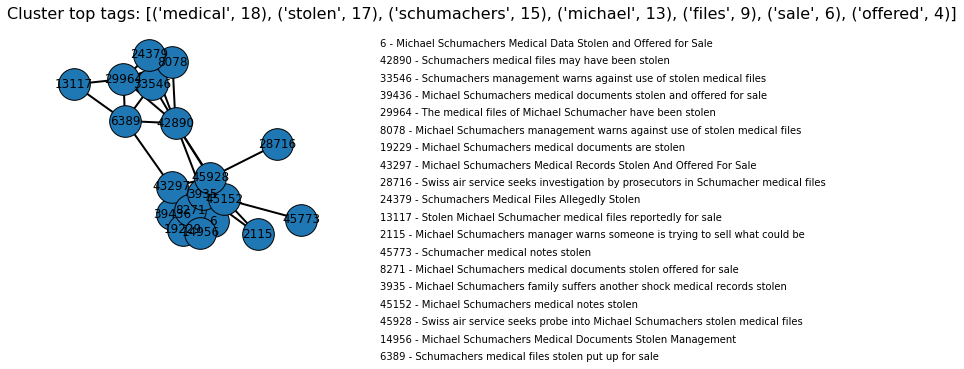

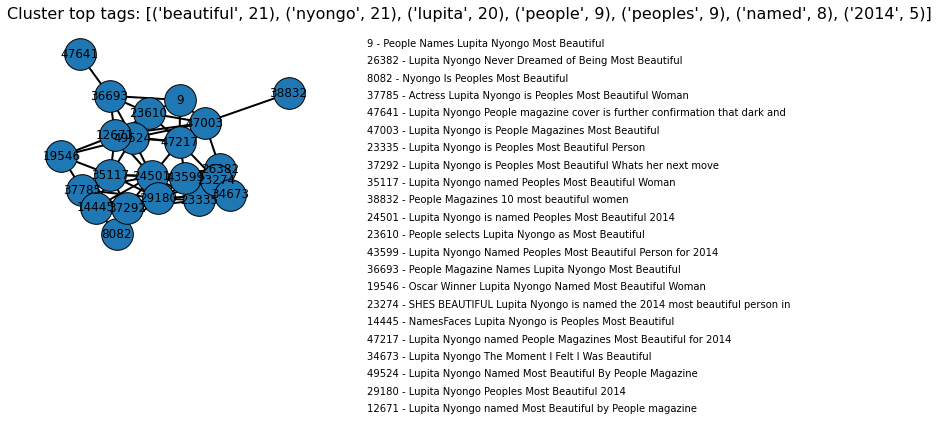

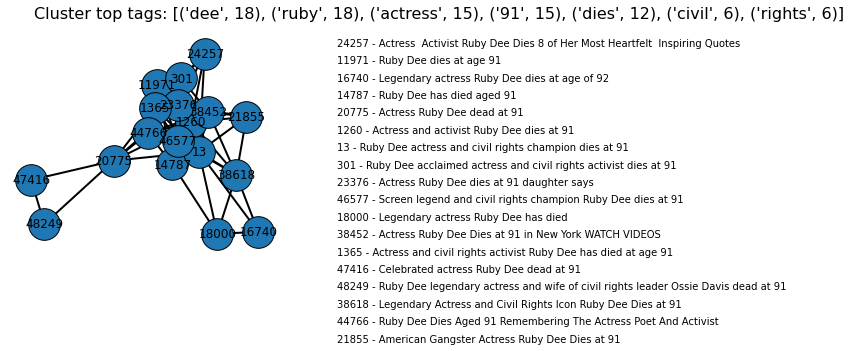

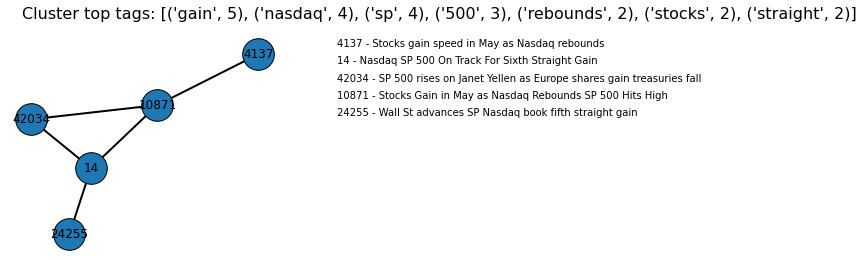

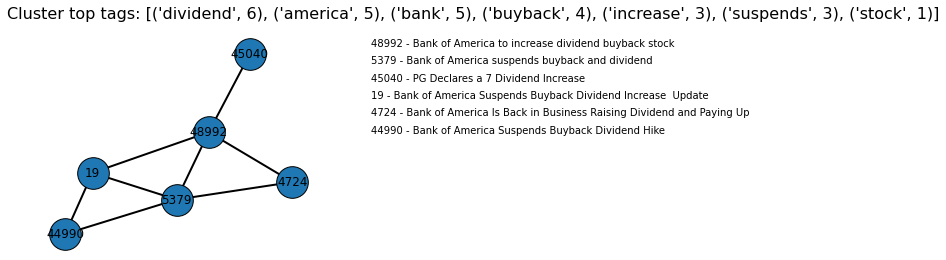

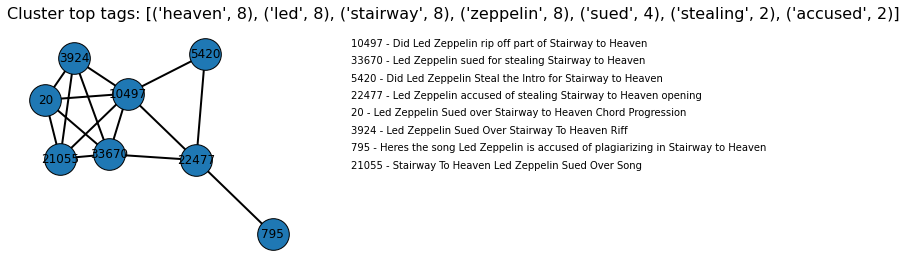

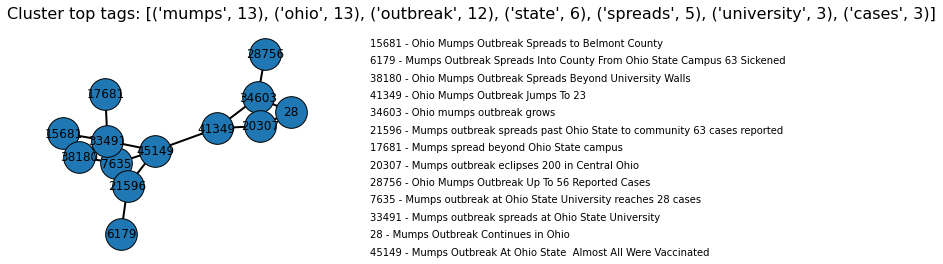

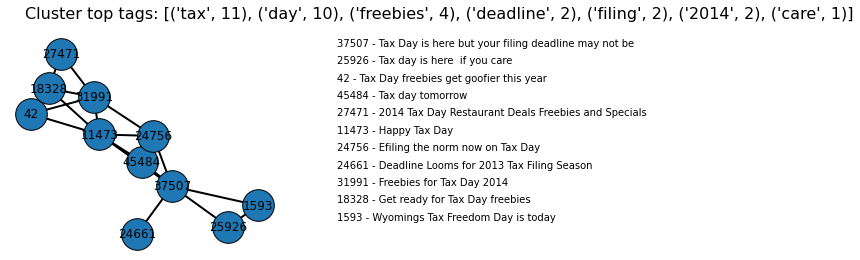

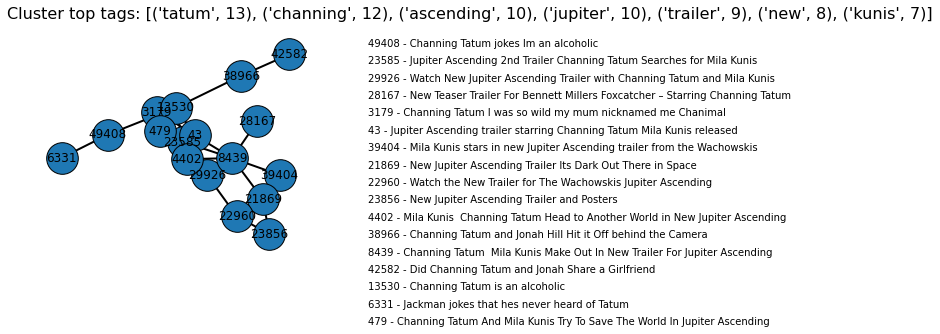

In [97]:
for tags, ids in clusters.items():
    if len(ids) >= MIN_ARTICLES and len(ids) <= MAX_ARTICLES:
        PRINT_CLUSTERS -= 1
        if PRINT_CLUSTERS >= 0:
            fig = plt.figure()
            plt.subplot(121)
            plt.subplots_adjust(left=-0.5)
            fig.suptitle("Cluster top tags: {0}".format(tags), fontsize=16)
            nx.draw(G.subgraph(ids), with_labels=True, width=2, node_size=1000, edgecolors='black')
            plt.subplot(122)
            y_coord = 0.95
            plt.axis('off') 
            for id in ids:
                plt.text(0, y_coord, "{0} - {1}".format(id, data_sample['TITLE'].iloc[id]))
                y_coord -= 0.08
        